# 用户画像-案例


### 基于用户搜索关键词数据为用户打上标签（年龄，性别，学历）

## 整体流程
<img src="./img/1.png" alt="FAO" width="500" align="right">
### （一）数据预处理
* 编码方式转换
* 对数据搜索内容进行分词
* 词性过滤
* 数据检查

### （二）特征选择
* 建立word2vec词向量模型
* 对所有搜索数据求平均向量

### （三）建模预测
* 不同机器学习模型对比
* 堆叠模型

### 将原始数据转换成utf-8编码，防止后续出现各种编码问题
由于原始数据比较大，在分词与过滤阶段会比较慢，这里我们选择了原始数据中的1W个

In [1]:
import csv

#原始数据存储路径
data_path = './data/user_tag_query.10W.TRAIN' 
#生成数据路径
csvfile = open(data_path + '-1w.csv', 'w')
writer = csv.writer(csvfile)
writer.writerow(['ID', 'age', 'Gender', 'Education', 'QueryList'])
#转换成utf-8编码的格式
with open(data_path, 'r',encoding='gb18030',errors='ignore') as f:
    lines = f.readlines()
    for line in lines[0:10000]:
        try:
            line.strip()          
            data = line.split("\t")
            writedata = [data[0], data[1], data[2], data[3]]
            querystr = ''
            data[-1]=data[-1][:-1]
            for d in data[4:]:
                try:
                    cur_str = d.encode('utf8')
                    cur_str = cur_str.decode('utf8')
                    querystr += cur_str + '\t'
                except:
                    continue
                    #print (data[0][0:10])
            querystr = querystr[:-1]
            writedata.append(querystr)
            writer.writerow(writedata)
        except:
            #print (data[0][0:20])
            continue

测试集的编码转换方式同上

In [2]:
data_path = './data/user_tag_query.10W.TEST'

csvfile = open(data_path + '-1w.csv', 'w')
writer = csv.writer(csvfile)
writer.writerow(['ID', 'QueryList'])
with open(data_path, 'r',encoding='gb18030',errors='ignore') as f:
    lines = f.readlines()
    for line in lines[0:10000]:
        try:
            data = line.split("\t")
            writedata = [data[0]]
            querystr = ''
            data[-1]=data[-1][:-1]
            for d in data[1:]:
                try:                  
                    cur_str = d.encode('utf8')
                    cur_str = cur_str.decode('utf8')
                    querystr += cur_str + '\t'               
                except:
                    #print (data[0][0:10])
                    continue
            querystr = querystr[:-1]
            writedata.append(querystr)
            writer.writerow(writedata)
        except:
            #print (data[0][0:20])
            continue

### 生成对应的数据表

In [3]:
import pandas as pd

#编码转换完成的数据，取的是1W的子集
trainname = './data/user_tag_query.10W.TRAIN-1w.csv'
testname = './data/user_tag_query.10W.TEST-1w.csv'

data = pd.read_csv(trainname,encoding='gbk')
print (data.info())

#分别生成三种标签数据（性别，年龄，学历）
data.age.to_csv("./data/train_age.csv", index=False)
data.Gender.to_csv("./data/train_gender.csv", index=False)
data.Education.to_csv("./data/train_education.csv", index=False)
#将搜索数据单独拿出来
data.QueryList.to_csv("./data/train_querylist.csv", index=False)

data = pd.read_csv(testname,encoding='gbk')
print (data.info())

data.QueryList.to_csv("./data/test_querylist.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9988 entries, 0 to 9987
Data columns (total 5 columns):
ID           9988 non-null object
age          9988 non-null int64
Gender       9988 non-null int64
Education    9988 non-null int64
QueryList    9988 non-null object
dtypes: int64(3), object(2)
memory usage: 390.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9978 entries, 0 to 9977
Data columns (total 2 columns):
ID           9978 non-null object
QueryList    9978 non-null object
dtypes: object(2)
memory usage: 156.0+ KB
None


### 对用户的搜索数据进行分词与词性过滤
这里需要分别对训练集和测试集进行相同的操作，路径名字要改动一下

In [5]:
import pandas as pd
import jieba.analyse
import time
import jieba
import jieba.posseg
import os, sys


def input(trainname):
    traindata = []
    with open(trainname, 'rb') as f:
        line = f.readline()
        count = 0
        while line:
            try:
                traindata.append(line)
                count += 1
            except:
                print ("error:", line, count)
            line=f.readline()
    return traindata
start = time.clock()

filepath = './data/test_querylist.csv'
QueryList = input(filepath)

writepath = './data/test_querylist_writefile-1w.csv'
csvfile = open(writepath, 'w')

POS = {}
for i in range(len(QueryList)):
    #print (i)
    if i%2000 == 0 and i >=1000:
        print (i,'finished') 
    s = []
    str = ""
    words = jieba.posseg.cut(QueryList[i])# 带有词性的精确分词模式
    allowPOS = ['n','v','j']
    for word, flag in words:
        POS[flag]=POS.get(flag,0)+1
        if (flag[0] in allowPOS) and len(word)>=2:
            str += word + " "
            
    cur_str = str.encode('utf8')
    cur_str = cur_str.decode('utf8')
    s.append(cur_str)
    
    csvfile.write(" ".join(s)+'\n')
csvfile.close()

end = time.clock()
print ("total time: %f s" % (end - start))

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\lomo1\AppData\Local\Temp\jieba.cache
Loading model cost 1.069 seconds.
Prefix dict has been built succesfully.


2000 finished
4000 finished
6000 finished
8000 finished
total time: 617.490211 s


### 使用Gensim库建立word2vec词向量模型
### 参数定义：
-  sentences：可以是一个list
-  sg： 用于设置训练算法，默认为0，对应CBOW算法；sg=1则采用skip-gram算法。
-  size：是指特征向量的维度，默认为100。大的size需要更多的训练数据,但是效果会更好. 推荐值为几十到几百。
-  window：表示当前词与预测词在一个句子中的最大距离是多少
-  alpha: 是学习速率
-  seed：用于随机数发生器。与初始化词向量有关。
-  min_count: 可以对字典做截断. 词频少于min_count次数的单词会被丢弃掉, 默认值为5
-  max_vocab_size: 设置词向量构建期间的RAM限制。如果所有独立单词个数超过这个，则就消除掉其中最不频繁的一个。每一千万个单词需要大约1GB的RAM。设置成None则没有限制。

-  workers参数控制训练的并行数。
-  hs: 如果为1则会采用hierarchica·softmax技巧。如果设置为0（defau·t），则negative sampling会被使用。
-  negative: 如果>0,则会采用negativesamp·ing，用于设置多少个noise words
-  iter： 迭代次数，默认为5

In [21]:
from gensim.models import word2vec
#将数据变换成list of list格式
train_path = './data/train_querylist_writefile-1w.csv'
with open(train_path, 'r') as f:
    My_list = []
    lines = f.readlines()
    for line in lines:
        cur_list = []
        line = line.strip()
        data = line.split(" ")
        for d in data:
            cur_list.append(d)
        My_list.append(cur_list)
    
    model = word2vec.Word2Vec(My_list, size=300, window=10,workers=4)  
    savepath = '1w_word2vec_' + '300'+'.model' # 保存model的路径

    model.save(savepath)

E:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [36]:
model.most_similar("大哥")

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('灾厄', 0.8946874737739563),
 ('苍月', 0.887350857257843),
 ('摩根', 0.8868879675865173),
 ('叛徒', 0.8853718638420105),
 ('爱德华', 0.8781758546829224),
 ('大麻', 0.8780295848846436),
 ('神明', 0.8776618242263794),
 ('张一', 0.8761001825332642),
 ('温瑞安', 0.8757286071777344),
 ('迷妹', 0.8735343217849731)]

In [37]:
model.most_similar("清华")

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('清华大学', 0.9328478574752808),
 ('北京大学', 0.921661913394928),
 ('特长生', 0.9194291830062866),
 ('北大', 0.9190258979797363),
 ('复旦大学', 0.913669228553772),
 ('中国人民大学', 0.9083595275878906),
 ('委员', 0.9013963341712952),
 ('哈佛大学', 0.9010764360427856),
 ('升学', 0.9006794691085815),
 ('文艺部', 0.8920862674713135)]

### 加载训练好的word2vec模型，求用户搜索结果的平均向量

In [41]:
import gensim
import numpy as np
file_name = './data/train_querylist_writefile-1w.csv'
cur_model = gensim.models.Word2Vec.load('1w_word2vec_300.model')
with open(file_name, 'r') as f:
    cur_index = 0
    lines = f.readlines()
    doc_cev = np.zeros((len(lines),300))
    for line in lines:
        word_vec = np.zeros((1,300))
        words = line.strip().split(' ')
        wrod_num = 0
        #求模型的平均向量
        for word in words:
            if word in cur_model:
                wrod_num += 1
                word_vec += np.array([cur_model[word]])
        doc_cev[cur_index] = word_vec / float(wrod_num)
        cur_index += 1

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  from ipykernel import kernelapp as app
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [44]:
doc_cev.shape

(9988, 300)

In [45]:
genderlabel = np.loadtxt(open('./data/train_gender.csv', 'r')).astype(int)
genderlabel.shape

(9988,)

In [46]:
educationlabel = np.loadtxt(open('./data/train_education.csv', 'r')).astype(int)
educationlabel.shape

(9988,)

In [47]:
agelabel = np.loadtxt(open('./data/train_age.csv', 'r')).astype(int)
agelabel.shape

(9988,)

In [50]:
def removezero(x, y):
        nozero = np.nonzero(y)
        y = y[nozero]
        x = np.array(x)
        x = x[nozero]
        return x, y
gender_train, genderlabel = removezero(doc_cev, genderlabel)
age_train, agelabel = removezero(doc_cev, agelabel)
education_train, educationlabel = removezero(doc_cev, educationlabel)
print (gender_train.shape,genderlabel.shape)
print (age_train.shape,agelabel.shape)
print (education_train.shape,educationlabel.shape)

(9756, 300) (9756,)
(9815, 300) (9815,)
(9064, 300) (9064,)


### 绘图函数，以性别为例，绘制混淆矩阵

In [51]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 测试集的构造方法和训练集一样

In [52]:
import numpy as np
file_name = './data/test_querylist_writefile-1w.csv'
cur_model = gensim.models.Word2Vec.load('1w_word2vec_300.model')
with open(file_name, 'r') as f:
    cur_index = 0
    lines = f.readlines()
    doc_cev = np.zeros((len(lines),300))
    for line in lines:
        word_vec = np.zeros((1,300))
        words = line.strip().split(' ')
        wrod_num = 0
        #求模型的平均向量
        for word in words:
            if word in cur_model:
                wrod_num += 1
                word_vec += np.array([cur_model[word]])
        doc_cev[cur_index] = word_vec / float(wrod_num)
        cur_index += 1

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


### 检查一下数据有木有问题

In [53]:
doc_cev.shape

(9978, 300)

In [54]:
doc_cev[6]

array([-9.25524114e-02, -1.08429363e-01,  2.02125483e-01, -3.81374098e-01,
        3.39909847e-01,  1.80289506e-02,  5.84929521e-02, -3.04199876e-01,
       -5.44574459e-02, -2.22755916e-01, -3.71586592e-02, -2.58024230e-01,
       -4.55392004e-03, -5.26326431e-01, -2.07032850e-01, -1.04809312e-01,
        1.35219665e-01,  1.38216157e-01, -3.02577168e-02,  5.51131216e-02,
        3.52472196e-02, -3.08656260e-01,  1.77739693e-01, -9.73291053e-02,
       -1.18894737e-01,  1.86371336e-01, -8.37501465e-02,  1.36852434e-01,
        1.68682465e-01, -5.10337123e-02, -2.80006557e-01, -1.78845235e-01,
       -3.32135643e-02, -2.31725154e-03, -6.58900214e-02,  1.90380394e-01,
        1.36062450e-01,  1.23377059e-01, -2.30646905e-01, -5.94165186e-01,
       -7.12540247e-02, -4.10801640e-02,  1.68106699e-02, -2.03900074e-01,
       -2.82240117e-02, -2.90883926e-01, -2.59285577e-01, -2.15492026e-02,
       -2.08729135e-01, -4.23674277e-01,  4.47212708e-02, -3.33749245e-01,
        3.28004781e-01, -

### 建立一个基础预测模型

0.8022540983606558
Recall metric in the testing dataset:  0.7400497512437811
accuracy metric in the testing dataset:  0.8022540983606558


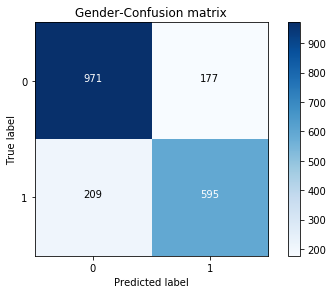

<Figure size 1440x1440 with 0 Axes>

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gender_train,genderlabel,test_size = 0.2, random_state = 0)

LR_model = LogisticRegression()

LR_model.fit(X_train,y_train)
y_pred = LR_model.predict(X_test)
print (LR_model.score(X_test,y_test))

cnf_matrix = confusion_matrix(y_test,y_pred)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

print("accuracy metric in the testing dataset: ", (cnf_matrix[1,1]+cnf_matrix[0,0])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[1,0]+cnf_matrix[0,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Gender-Confusion matrix')
plt.show()

0.8058401639344263
Recall metric in the testing dataset:  0.7288557213930348
accuracy metric in the testing dataset:  0.8058401639344263


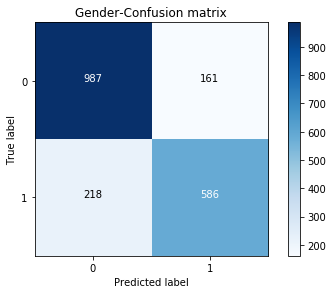

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gender_train,genderlabel,test_size = 0.2, random_state = 0)

RF_model = RandomForestClassifier(n_estimators=100,min_samples_split=5,max_depth=10)

RF_model.fit(X_train,y_train)
y_pred = RF_model.predict(X_test)
print (RF_model.score(X_test,y_test))

cnf_matrix = confusion_matrix(y_test,y_pred)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

print("accuracy metric in the testing dataset: ", (cnf_matrix[1,1]+cnf_matrix[0,0])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[1,0]+cnf_matrix[0,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Gender-Confusion matrix')
plt.show()

### 堆叠模型
<img src="./img/2.png" alt="FAO" width="700" >

In [61]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
clf1 = RandomForestClassifier(n_estimators=100,min_samples_split=5,max_depth=10)
clf2 = SVC()
clf3 = LogisticRegression()
basemodes = [
            ['rf', clf1],
            ['svm', clf2],
            ['lr', clf3]
            ]

In [62]:
from sklearn.cross_validation import KFold, StratifiedKFold
models = basemodes

#X_train, X_test, y_train, y_test

folds = list(KFold(len(y_train), n_folds=5, random_state=0))
print (len(folds))
S_train = np.zeros((X_train.shape[0], len(models)))
S_test = np.zeros((X_test.shape[0], len(models)))

for i, bm in enumerate(models):
    clf = bm[1]

    #S_test_i = np.zeros((y_test.shape[0], len(folds)))
    for j, (train_idx, test_idx) in enumerate(folds):
        X_train_cv = X_train[train_idx]
        y_train_cv = y_train[train_idx]
        X_val = X_train[test_idx]
        clf.fit(X_train_cv, y_train_cv)
        y_val = clf.predict(X_val)[:]
          
        S_train[test_idx, i] = y_val
    S_test[:,i] = clf.predict(X_test)

final_clf = RandomForestClassifier(n_estimators=100)
final_clf.fit(S_train,y_train)

print (final_clf.score(S_test,y_test))


5
0.7961065573770492
